In [1]:
import torch
from torch.utils.data import Dataset,DataLoader
import numpy as np
import os
from torchvision import datasets
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2 as cv
from sklearn.cluster import KMeans

In [2]:
img_folder = "/Data/Training/"
classes = {
            "Apple Granny Smith" : 0,
            "Apple Red 1" : 1,
            "Apple Golden 1" : 2,
            "Dates" : 3,
            "Nut Pecan" : 4,
            "Tangelo" : 5,
            "Kohlrabi": 6,
            "Plum" : 7,
            "Peach" : 8,
            "Walnut" : 9
        }

a. Traditional Data extraction

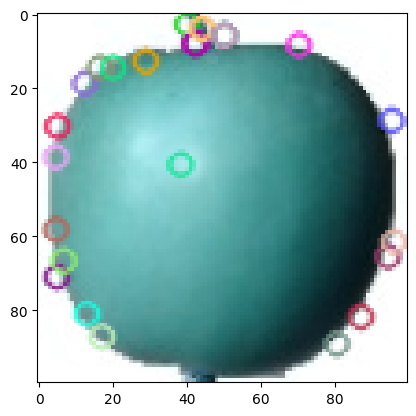

In [3]:
import cv2 as cv


img = cv.imread(r"Data/Training/Apple Granny Smith/0_100.jpg")
sift = cv.SIFT_create()

kp = sift.detect(img,None)

kp,des  = sift.compute(img,kp)
img=cv.drawKeypoints(img,kp,img)

import matplotlib.pyplot as plt

plt.imshow(img)

b. Create a new keypoints dataset 𝐾𝑃 that consists of all the keypoints from all the training images

In [4]:


# Function to extract keypoints from an image
def extract_keypoints(image_path, sift):
    img = cv.imread(image_path)
    kp = sift.detect(img, None)
    kp, des = sift.compute(img, kp)
    return kp, des

# Initialize SIFT object
sift = cv.SIFT_create()

# Initialize a dictionary to store keypoints for each class
train_keypoints = {}

# Iterate through each class directory
for class_name,idx in classes.items():
    train_keypoints[class_name] = []  # Initialize an empty list for the class
    class_dir = r"Data/Training/" + class_name + "/"
    # Iterate through each image in the class directory
    for filename in os.listdir(class_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Extract keypoints from the image
            image_path = os.path.join(class_dir, filename)
            kp, _ = extract_keypoints(image_path, sift)
            # Add keypoints to the list for the current class
            train_keypoints[class_name].append([list(kp),[idx]])



In [5]:
train_kp_x = []
train_kp_y = []

for i in train_keypoints.items():
    for X in i[1]:
        train_kp_x.append(X[0])
        train_kp_y.append(X[1])

print(train_kp_x[0],train_kp_y[1])


[< cv2.KeyPoint 0000020E41615FB0>, < cv2.KeyPoint 0000020E41615FE0>, < cv2.KeyPoint 0000020E41616010>, < cv2.KeyPoint 0000020E41616040>, < cv2.KeyPoint 0000020E41616A90>, < cv2.KeyPoint 0000020E41616AC0>, < cv2.KeyPoint 0000020E41616AF0>, < cv2.KeyPoint 0000020E41616B20>, < cv2.KeyPoint 0000020E41616B50>, < cv2.KeyPoint 0000020E41616B80>, < cv2.KeyPoint 0000020E41616BB0>, < cv2.KeyPoint 0000020E41616BE0>, < cv2.KeyPoint 0000020E41616C10>, < cv2.KeyPoint 0000020E41616C40>, < cv2.KeyPoint 0000020E41616C70>, < cv2.KeyPoint 0000020E41616CA0>, < cv2.KeyPoint 0000020E41616CD0>, < cv2.KeyPoint 0000020E41616D00>, < cv2.KeyPoint 0000020E41616D30>, < cv2.KeyPoint 0000020E41616D60>, < cv2.KeyPoint 0000020E41616D90>, < cv2.KeyPoint 0000020E41616DC0>, < cv2.KeyPoint 0000020E41617960>, < cv2.KeyPoint 0000020E41616E80>, < cv2.KeyPoint 0000020E41616E50>] [0]


In [6]:
# Extract coordinate values from train_kp_x
coords = []
for kp_list in train_kp_x:
    coords.extend([kp.pt for kp in kp_list])

# Convert the list of tuples to a NumPy array
data = np.array(coords)

# Initialize KMeans with 100 clusters
kmeans = KMeans(n_clusters=100, random_state=0)

# Fit the KMeans model to your data
kmeans.fit(data)

# Get the cluster labels for each data point
labels = kmeans.labels_

# Get the cluster centers
centroids = kmeans.cluster_centers_

c:\Users\kaasa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [7]:
# Initialize a dictionary to store the 100-D vectors for each image
train_image_vectors = {}

# Iterate through each class directory
for class_name, idx in classes.items():
    class_dir = r"Data/Training/" + class_name + "/"
    
    # Iterate through each image in the class directory
    for filename in os.listdir(class_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Extract keypoints and descriptors from the image
            image_path = os.path.join(class_dir, filename)
            kp, _ = extract_keypoints(image_path, sift)
            
            # Extract coordinate values from keypoints
            coords = np.array([kp_.pt for kp_ in kp])
            
            # Predict the cluster labels for each keypoint coordinate
            cluster_labels = kmeans.predict(coords)
            
            # Create a 100-D vector for the image by counting the number of keypoints in each cluster
            vector = np.zeros(100)
            for label in cluster_labels:
                vector[label] += 1
            
            # Add the 100-D vector to the dictionary with the image path as the key
            train_image_vectors[image_path] = vector

# Create a new 100-D dataset D
dataset_train = []
labels_train = []

for image_path, vector in train_image_vectors.items():
    class_name = image_path.split("/")[-2]  # Extract the class name from the image path
    label = classes[class_name]  # Get the corresponding label for the class
    
    dataset_train.append(vector)
    labels_train.append(label)

# Convert dataset_train and labels_train to NumPy arrays
dataset_train = np.array(dataset_train)
labels_train = np.array(labels_train)

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#from sklearn.preprocessing import StandardScaler

# Normalize the dataset
#scaler = StandardScaler()
#dataset_normalized = scaler.fit_transform(dataset_train)

# Perform PCA on the normalized dataset
pca = PCA(n_components=2)
dataset_pca = pca.fit_transform(dataset_train)


In [9]:
len(dataset_pca)

5123

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


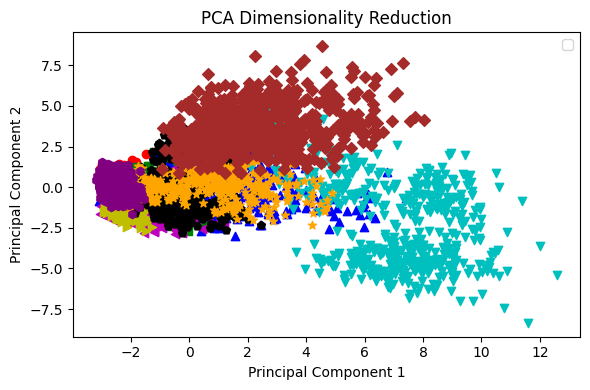

In [10]:

# Create a dictionary to map class labels to colors/symbols
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']
symbols = ['o', 's', '^', 'v', '<', '>', 'p', '*', 'h', 'D']
class_colors = {label: color for label, color in zip(classes.values(), colors)}
class_symbols = {label: symbol for label, symbol in zip(classes.values(), symbols)}

# Plot the 2D points using different colors/symbols for each class
fig, ax = plt.subplots(figsize=(6, 4))  # Adjust the figure size as needed
for i, label in enumerate(labels_train):
    ax.scatter(dataset_pca[i, 0], dataset_pca[i, 1], c=class_colors[label], marker=class_symbols[label])

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('PCA Dimensionality Reduction')
ax.legend()

plt.tight_layout()
plt.show()

In [11]:
# Initialize a dictionary to store the 100-D vectors for each image
test_image_vectors = {}

# Iterate through each class directory
for class_name, idx in classes.items():
    class_dir = r"Data/Test/" + class_name + "/"
    
    # Iterate through each image in the class directory
    for filename in os.listdir(class_dir):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Extract keypoints and descriptors from the image
            image_path = os.path.join(class_dir, filename)
            kp, _ = extract_keypoints(image_path, sift)
            
            # Extract coordinate values from keypoints
            coords = np.array([kp_.pt for kp_ in kp])
            
            # Predict the cluster labels for each keypoint coordinate
            cluster_labels = kmeans.predict(coords)
            
            # Create a 100-D vector for the image by counting the number of keypoints in each cluster
            vector = np.zeros(100)
            for label in cluster_labels:
                vector[label] += 1
            
            # Add the 100-D vector to the dictionary with the image path as the key
            test_image_vectors[image_path] = vector

# Create a new 100-D dataset D
dataset_test = []
labels_test = []

for image_path, vector in test_image_vectors.items():
    class_name = image_path.split("/")[-2]  # Extract the class name from the image path
    label = classes[class_name]  # Get the corresponding label for the class
    
    dataset_test.append(vector)
    labels_test.append(label)

# Convert dataset_test and labels_test to NumPy arrays
dataset_test = np.array(dataset_test)
labels_test = np.array(labels_test)

Training SVM with kernel: linear


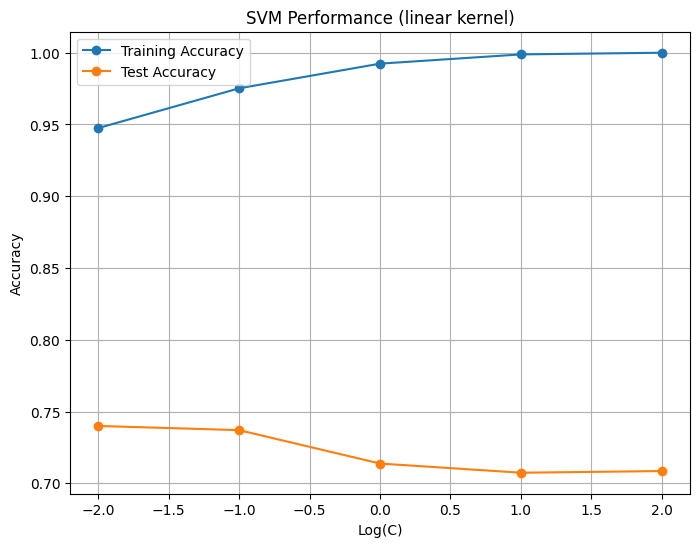

Training SVM with kernel: rbf


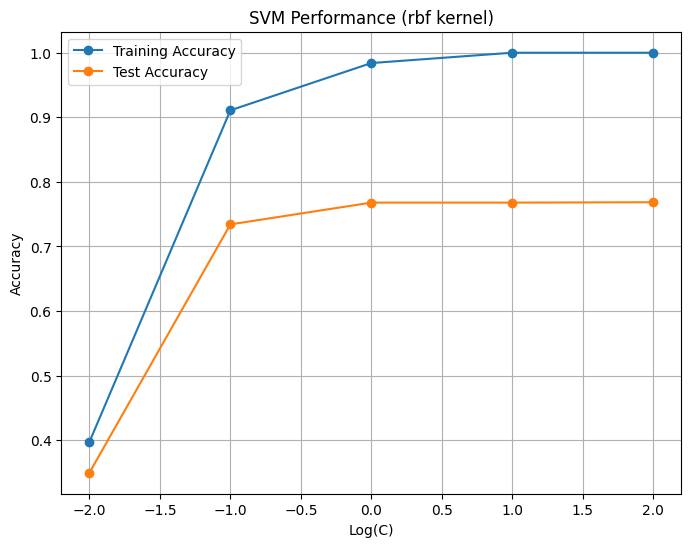

Training SVM with kernel: poly


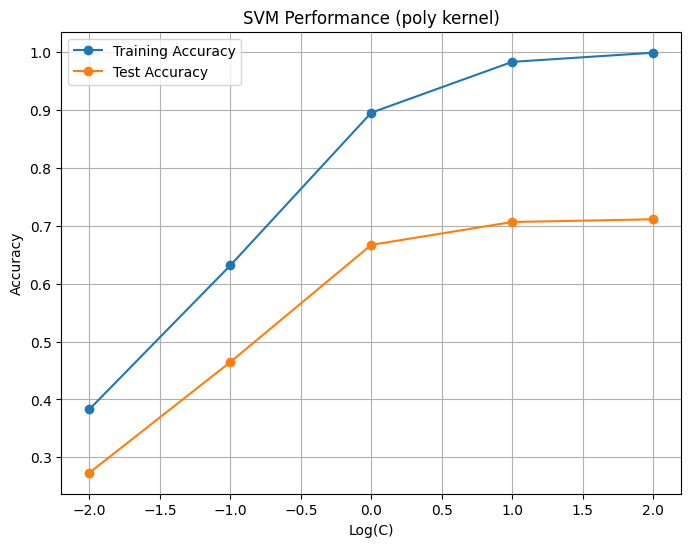

Training SVM with kernel: sigmoid


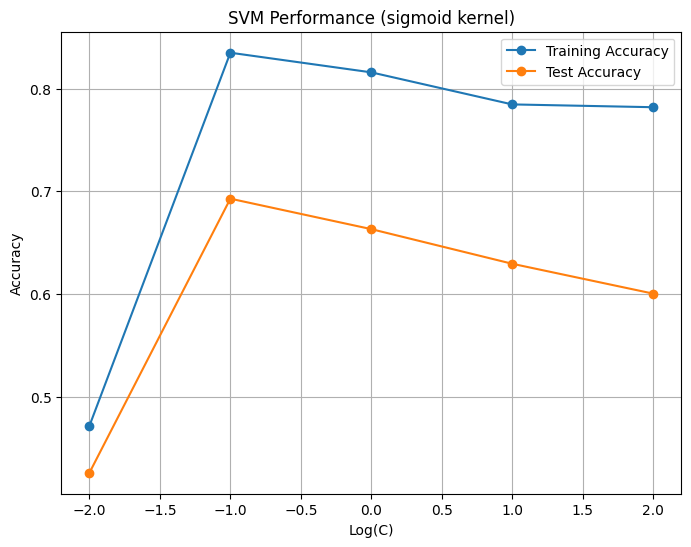

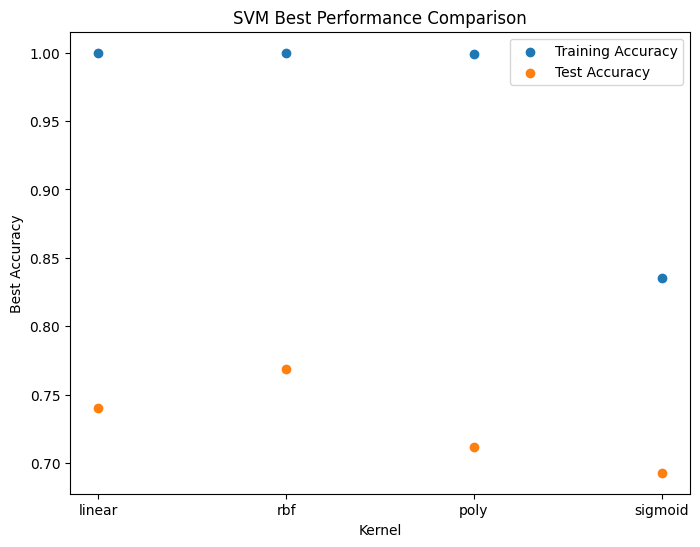

In [12]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np

# Define the C parameters to test
c_values = [0.01, 0.1, 1.0, 10, 100]
log_c_values = np.log10(c_values)
kernels = ['linear', 'rbf', 'poly', 'sigmoid']

# Create dictionaries to store the best accuracy for each kernel
best_train_accuracy = {}
best_test_accuracy = {}

# Perform model selection and training for each kernel
for kernel in kernels:
    print(f"Training SVM with kernel: {kernel}")
    
    train_accuracies = []
    test_accuracies = []
    
    for c in c_values:
        # Create and train the SVM model
        svm = SVC(C=c, kernel=kernel)
        svm.fit(dataset_train, labels_train)
        
        # Evaluate the model on the training data
        train_predictions = svm.predict(dataset_train)
        train_accuracy = accuracy_score(labels_train, train_predictions)
        train_accuracies.append(train_accuracy)
        
        # Evaluate the model on the test data
        test_predictions = svm.predict(dataset_test)
        test_accuracy = accuracy_score(labels_test, test_predictions)
        test_accuracies.append(test_accuracy)
    
    # Plot the performance graph for the current kernel
    plt.figure(figsize=(8, 6))
    plt.plot(log_c_values, train_accuracies, marker='o', label='Training Accuracy')
    plt.plot(log_c_values, test_accuracies, marker='o', label='Test Accuracy')
    plt.xlabel('Log(C)')
    plt.ylabel('Accuracy')
    plt.title(f'SVM Performance ({kernel} kernel)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Store the best accuracy for the current kernel
    best_train_accuracy[kernel] = max(train_accuracies)
    best_test_accuracy[kernel] = max(test_accuracies)

# Plot the best performance comparison graph
plt.figure(figsize=(8, 6))
plt.scatter(kernels, [best_train_accuracy[k] for k in kernels], label='Training Accuracy')
plt.scatter(kernels, [best_test_accuracy[k] for k in kernels], label='Test Accuracy')
plt.xlabel('Kernel')
plt.ylabel('Best Accuracy')
plt.title('SVM Best Performance Comparison')
plt.legend()
plt.show()

In [17]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class FruitDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = [
            "Apple Granny Smith",
            "Apple Red 1",
            "Apple Golden 1",
            "Dates",
            "Nut Pecan",
            "Tangelo",
            "Kohlrabi",
            "Plum",
            "Peach",
            "Walnut"
        ]
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        self.samples = []
        for cls_name in self.classes:
            cls_dir = os.path.join(data_dir, cls_name)
            for img_name in os.listdir(cls_dir):
                img_path = os.path.join(cls_dir, img_name)
                self.samples.append((img_path, self.class_to_idx[cls_name]))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        img_path, label = self.samples[index]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

Epoch [1/20], Train Accuracy: 0.8837, Test Accuracy: 0.9697
Epoch [2/20], Train Accuracy: 0.9924, Test Accuracy: 0.9895
Epoch [3/20], Train Accuracy: 1.0000, Test Accuracy: 0.9895
Epoch [4/20], Train Accuracy: 1.0000, Test Accuracy: 0.9895
Epoch [5/20], Train Accuracy: 1.0000, Test Accuracy: 0.9878
Epoch [6/20], Train Accuracy: 1.0000, Test Accuracy: 0.9884
Epoch [7/20], Train Accuracy: 1.0000, Test Accuracy: 0.9884
Epoch [8/20], Train Accuracy: 1.0000, Test Accuracy: 0.9878
Epoch [9/20], Train Accuracy: 1.0000, Test Accuracy: 0.9884
Epoch [10/20], Train Accuracy: 1.0000, Test Accuracy: 0.9878
Epoch [11/20], Train Accuracy: 1.0000, Test Accuracy: 0.9878
Epoch [12/20], Train Accuracy: 1.0000, Test Accuracy: 0.9878
Epoch [13/20], Train Accuracy: 1.0000, Test Accuracy: 0.9878
Epoch [14/20], Train Accuracy: 1.0000, Test Accuracy: 0.9872
Epoch [15/20], Train Accuracy: 1.0000, Test Accuracy: 0.9872
Epoch [16/20], Train Accuracy: 1.0000, Test Accuracy: 0.9866
Epoch [17/20], Train Accuracy: 1.

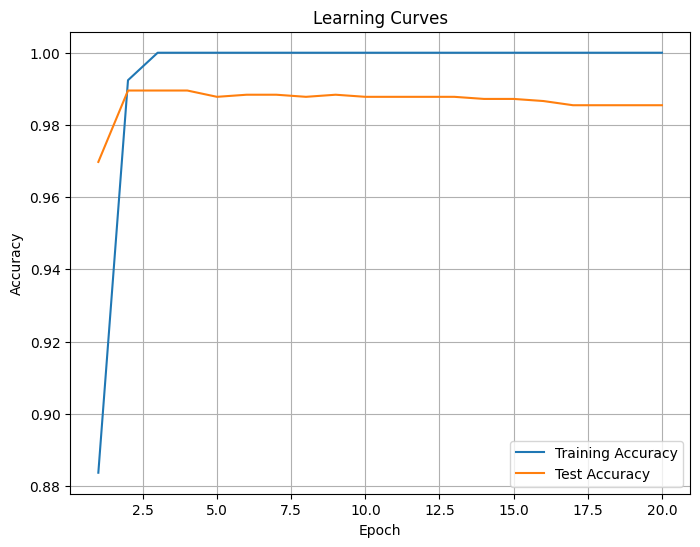

In [33]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt


# Define the data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create instances of the custom dataset
train_dataset = FruitDataset('Data/Training', transform=transform)
test_dataset = FruitDataset('Data/Test', transform=transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the CNN model
class FruitCNN(nn.Module):
    def __init__(self, num_classes):
        super(FruitCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(8 * 112 * 112, 32)  # Update the input size
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, num_classes)
        
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create an instance of the CNN model
num_classes = len(train_dataset.classes)
model = FruitCNN(num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Train the model
num_epochs = 20
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_correct = 0
    train_total = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_accuracy = train_correct / train_total
    train_accuracies.append(train_accuracy)
    
    model.eval()
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_accuracy = test_correct / test_total
    test_accuracies.append(test_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plot the learning curves
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\kaasa\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kaasa\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Train Accuracy: 0.9219, Test Accuracy: 0.9930
Epoch [2/10], Train Accuracy: 0.9973, Test Accuracy: 0.9983
Epoch [3/10], Train Accuracy: 0.9992, Test Accuracy: 0.9971
Epoch [4/10], Train Accuracy: 0.9996, Test Accuracy: 0.9988
Epoch [5/10], Train Accuracy: 0.9996, Test Accuracy: 0.9988
Epoch [6/10], Train Accuracy: 0.9996, Test Accuracy: 0.9988
Epoch [7/10], Train Accuracy: 0.9986, Test Accuracy: 0.9994
Epoch [8/10], Train Accuracy: 1.0000, Test Accuracy: 0.9994
Epoch [9/10], Train Accuracy: 1.0000, Test Accuracy: 0.9988
Epoch [10/10], Train Accuracy: 0.9996, Test Accuracy: 0.9994


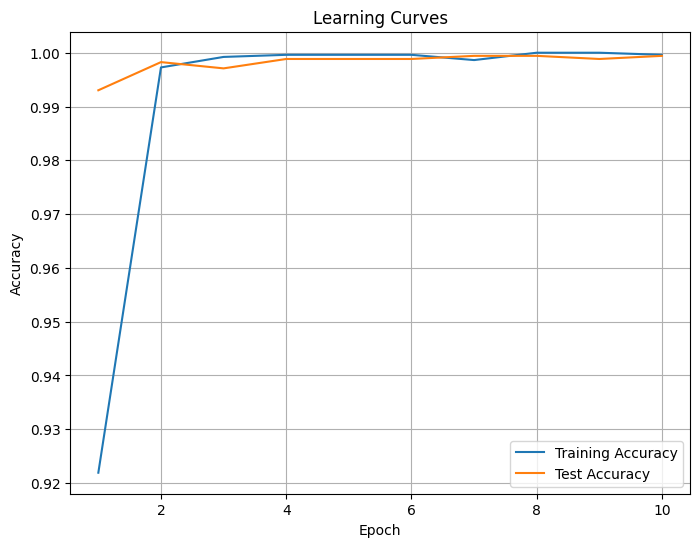

SVM Train Accuracy: 1.0000
SVM Test Accuracy: 0.9994


In [37]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Define the data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create instances of the custom dataset
train_dataset = FruitDataset('Data/Training', transform=transform)
test_dataset = FruitDataset('Data/Test', transform=transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the last fully connected layer
num_features = model.fc.in_features
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(num_features, num_classes)

# Move the model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

# Train the model
num_epochs = 10
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_accuracy = train_correct / train_total
    train_accuracies.append(train_accuracy)

    model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = test_correct / test_total
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plot the learning curves
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.grid(True)
plt.show()

# Extract features from the last convolutional layer
features = {}
def hook(module, input, output):
    features['last_conv'] = output.detach()

model.layer4[-1].register_forward_hook(hook)

# Extract features from the training dataset
train_features = []
train_labels = []

model.eval()
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        model(images)
        train_features.append(features['last_conv'].view(images.size(0), -1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

train_features = np.concatenate(train_features, axis=0)
train_labels = np.array(train_labels)

# Extract features from the test dataset
test_features = []
test_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        model(images)
        test_features.append(features['last_conv'].view(images.size(0), -1).cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_features = np.concatenate(test_features, axis=0)
test_labels = np.array(test_labels)

# Train an SVM model using the extracted features
svm = SVC(kernel='rbf', C=10)  # Use the best kernel and C value from Question 4(e)
svm.fit(train_features, train_labels)

# Evaluate the SVM model
train_predictions = svm.predict(train_features)
train_accuracy = accuracy_score(train_labels, train_predictions)
print(f"SVM Train Accuracy: {train_accuracy:.4f}")

test_predictions = svm.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f"SVM Test Accuracy: {test_accuracy:.4f}")

c:\Users\kaasa\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kaasa\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Train Accuracy: 0.9740, Test Accuracy: 1.0000
Epoch [2/10], Train Accuracy: 0.9908, Test Accuracy: 0.9988
Epoch [3/10], Train Accuracy: 0.9961, Test Accuracy: 1.0000
Epoch [4/10], Train Accuracy: 0.9918, Test Accuracy: 0.9133
Epoch [5/10], Train Accuracy: 0.9920, Test Accuracy: 1.0000
Epoch [6/10], Train Accuracy: 0.9945, Test Accuracy: 1.0000
Epoch [7/10], Train Accuracy: 0.9865, Test Accuracy: 0.9907
Epoch [8/10], Train Accuracy: 0.9961, Test Accuracy: 1.0000
Epoch [9/10], Train Accuracy: 0.9982, Test Accuracy: 0.9837
Epoch [10/10], Train Accuracy: 0.9926, Test Accuracy: 0.9994


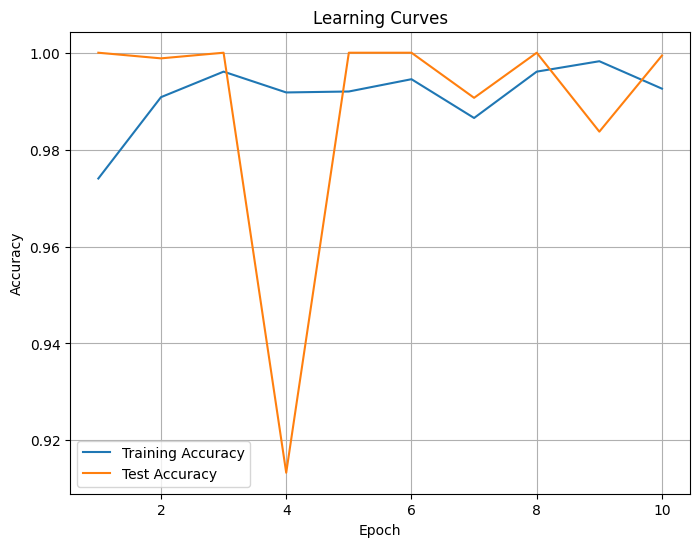

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
import matplotlib.pyplot as plt

# Define the data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create instances of the custom dataset
train_dataset = FruitDataset('Data/Training', transform=transform)
test_dataset = FruitDataset('Data/Test', transform=transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load the pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Replace the last fully connected layer
num_features = model.fc.in_features
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(num_features, num_classes)

# Move the model to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Train the model
num_epochs = 10
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_correct = 0
    train_total = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_accuracy = train_correct / train_total
    train_accuracies.append(train_accuracy)
    
    model.eval()
    test_correct = 0
    test_total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    
    test_accuracy = test_correct / test_total
    test_accuracies.append(test_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plot the learning curves
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.grid(True)
plt.show()